# Declare Global Parameters

In [19]:
# Define Weights
gene_expression_weight = 0.92
clinical_sd_weight = 0.00
clinical_corr_weight = 0.08

# Locations of Files
input_filename = (
    "~/oneai-rnd-mdm-pseudo_ordering/input_output/dataset_forPseudoOrdering.tsv"
)
clinical_info_file = (
    "~/oneai-rnd-mdm-pseudo_ordering/input_output/gse193309_clinicaldata.tsv"
)
output_filename = (
    "~/oneai-rnd-mdm-pseudo_ordering/input_output/output_pseudoOrdering.tsv"
)

# Libraries

In [20]:
import random
import sys
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import PolynomialFeatures

pd.set_option("display.max_rows", 600)

import warnings

warnings.filterwarnings("ignore")



# Import Class

In [21]:
sys.path.insert(0, "../src/")
from utils.utils_pseudo_ordering import pseudo_ordering

func = pseudo_ordering()

# Data

## Clinical Info

In [22]:
df_nb = pd.read_csv(clinical_info_file, sep="\t")
df_nb.head()

,samples,clinical_score
0,AD_02_vis01,48.0
1,AD_02_vis02,15.5
2,AD_02_vis03,23.4
3,AD_02_vis04,25.8
4,AD_02_vis05,23.9


## Read Gene Expression Data

In [23]:
df0 = pd.read_csv(input_filename, sep="\t")
# Removing the outlier sample
df0.drop(["AD_27_vis01"], axis=1, inplace=True)
df = df0.drop(columns=["Geneid"])
df = df.apply(pd.to_numeric)
df0.head(2)

,Geneid,AD_13_vis03,AD_25_vis03,AD_06_vis05,AD_06_vis04,AD_17_vis02,AD_25_vis04,AD_13_vis05,AD_15_vis04,AD_13_vis01,...,AD_23_vis01,AD_08_vis01,AD_07_vis01,AD_13_vis04,AD_26_vis01,AD_25_vis02,AD_16_vis04,AD_03_vis01,AD_22_vis05,AD_09_vis01
0,FAM41C,-2.651368,-5.513242,-5.247777,-5.230043,-5.824341,-1.395987,-3.088146,-5.442751,-5.691213,...,-5.244720,-5.408114,-1.727310,-1.392411,-0.089998,-1.620567,-5.301667,-5.020314,-2.777684,-5.425776
1,SAMD11,1.282744,-0.383959,-1.340887,-1.323153,-5.824341,0.188975,-0.280791,-5.442751,-0.136624,...,-2.074795,-1.015797,-0.328761,-0.830532,0.995393,2.286323,-2.979739,-2.212959,-0.540645,-1.725336


# Initial Sample Ordering

In [24]:
# Common samples between gene expression and clinical data
sampleNames = list(set(df.columns))
sampleNames = list(set(sampleNames) & set(df_nb["samples"]))

# Filter Clinical Data 
df_nb = df_nb[df_nb["samples"].isin(sampleNames)]

print(len(sampleNames))
print(sampleNames)

45
['AD_02_vis05', 'AD_06_vis05', 'AD_24_vis01', 'AD_02_vis02', 'AD_25_vis01', 'AD_04_vis01', 'AD_02_vis01', 'AD_25_vis03', 'AD_29_vis01', 'AD_03_vis01', 'AD_11_vis02', 'AD_13_vis03', 'AD_14_vis01', 'AD_13_vis05', 'AD_15_vis04', 'AD_16_vis01', 'AD_16_vis04', 'AD_06_vis03', 'AD_16_vis05', 'AD_09_vis01', 'AD_22_vis05', 'AD_23_vis03', 'AD_26_vis01', 'AD_15_vis03', 'AD_25_vis02', 'AD_06_vis02', 'AD_13_vis01', 'AD_16_vis02', 'AD_25_vis04', 'AD_06_vis04', 'AD_09_vis02', 'AD_23_vis02', 'AD_02_vis04', 'AD_02_vis03', 'AD_13_vis02', 'AD_16_vis03', 'AD_11_vis01', 'AD_08_vis01', 'AD_23_vis01', 'AD_06_vis01', 'AD_13_vis04', 'AD_07_vis01', 'AD_30_vis01', 'AD_15_vis05', 'AD_17_vis02']


In [25]:
# Initial sample ordering by visit
## This is to build indexes for each patient and obtain chronology of samples
smp_order_init = (
    [x for x in sampleNames if x.endswith("vis01")]
    + [x for x in sampleNames if x.endswith("vis02")]
    + [x for x in sampleNames if x.endswith("vis03")]
    + [x for x in sampleNames if x.endswith("vis04")]
    + [x for x in sampleNames if x.endswith("vis05")]
    + [x for x in sampleNames if x.endswith("vis06")]
)
print(smp_order_init)
df_gex = df.reindex(columns=smp_order_init)
print(df_gex.shape)

['AD_24_vis01', 'AD_25_vis01', 'AD_04_vis01', 'AD_02_vis01', 'AD_29_vis01', 'AD_03_vis01', 'AD_14_vis01', 'AD_16_vis01', 'AD_09_vis01', 'AD_26_vis01', 'AD_13_vis01', 'AD_11_vis01', 'AD_08_vis01', 'AD_23_vis01', 'AD_06_vis01', 'AD_07_vis01', 'AD_30_vis01', 'AD_02_vis02', 'AD_11_vis02', 'AD_25_vis02', 'AD_06_vis02', 'AD_16_vis02', 'AD_09_vis02', 'AD_23_vis02', 'AD_13_vis02', 'AD_17_vis02', 'AD_25_vis03', 'AD_13_vis03', 'AD_06_vis03', 'AD_23_vis03', 'AD_15_vis03', 'AD_02_vis03', 'AD_16_vis03', 'AD_15_vis04', 'AD_16_vis04', 'AD_25_vis04', 'AD_06_vis04', 'AD_02_vis04', 'AD_13_vis04', 'AD_02_vis05', 'AD_06_vis05', 'AD_13_vis05', 'AD_16_vis05', 'AD_22_vis05', 'AD_15_vis05']
(4576, 45)


# Patient Indicies

In [26]:
samples = list(df_gex.columns)
ind0, ante_pt, con_pt = func.patient_index(samples, patient_delimter_loc=2)

num_samples = df_gex.shape[1]

weights = {
    "gene_expression_weight": gene_expression_weight,
    "clinical_sd_weight": clinical_sd_weight,
    "clinical_corr_weight": clinical_corr_weight,
}

indices = {"index_init": ind0, "index_antecedent": ante_pt, "index_consequent": con_pt}

In [27]:
# Verify Patient Antecedent and Consequent
# ind0
# ante_pt
# con_pt

# EM

## With Clinical Scores

In [28]:
(
    rmse_err_min,
    rmse_err_list,
    z_list,
    smp_ord_list,
    coefs_list,
) = func.em_with_clinical_correlation(
    indices, num_samples, df_gex, df_nb, weights, num_init=25, num_iter=20
)


## Only Gene Expression

In [29]:
# rmse_err_min, rmse_err_list, z_list, smp_ord_list, coefs_list = func.em_onlygex(indices, num_samples, df_gex, num_init=10, num_iter=20)

# Plot RMSE & Clinical Scores

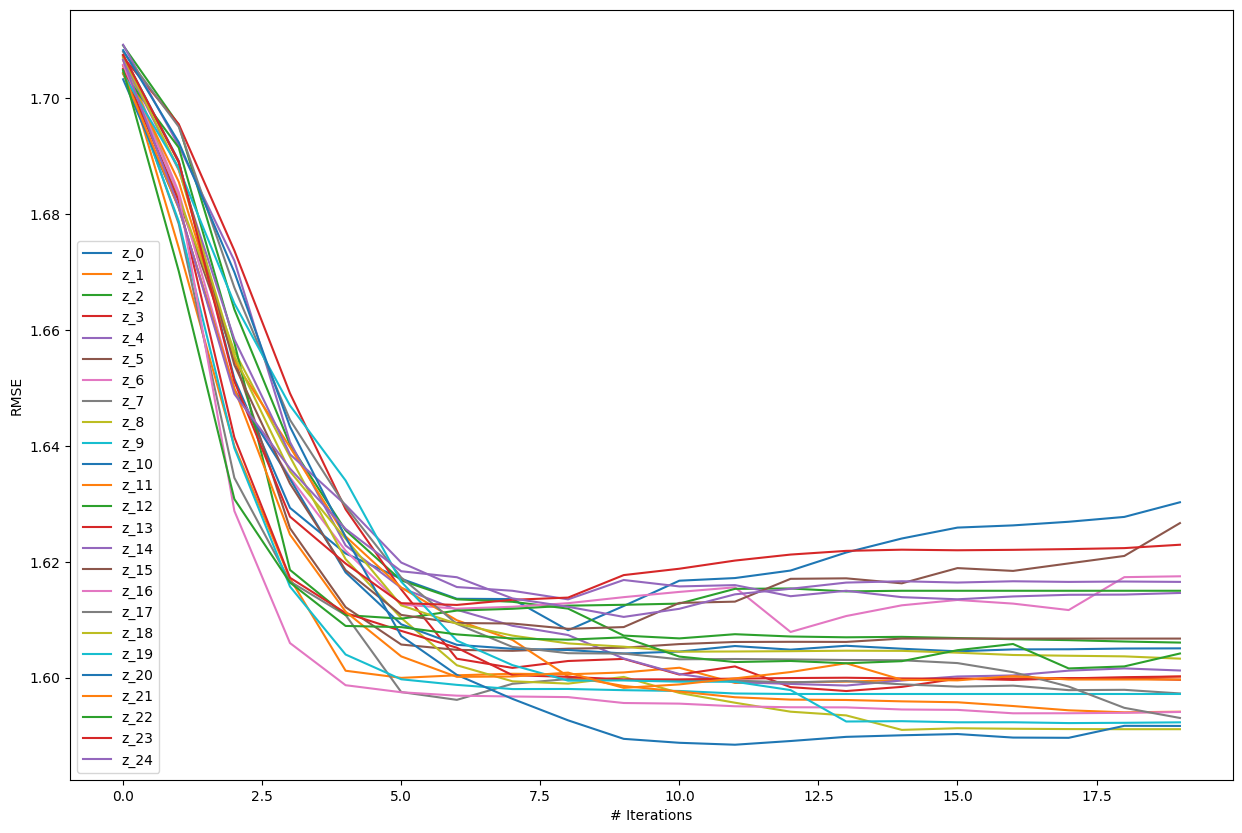

In [30]:
plt.figure(figsize=(15, 10))
for i in range(len(rmse_err_list)):
    l = "z_" + str(i)
    plt.plot(rmse_err_list[i], label=l)
plt.xlabel("# Iterations")
plt.ylabel("RMSE")
plt.legend()
plt.show()

# Sample Ordering

In [31]:
# Choose sample ordering using the least RMSE score

#min_index = rmse_selected.index(min(rmse_selected))
#print("Minimum RMSE Index:{}, RMSE:{}".format(min_index, rmse_selected[min_index]))

# When using only gene expression, use the below commented code
min_index = rmse_err_min.index(min(rmse_err_min))
print("RMSE: ", rmse_err_min[min_index])
print("Sample Ordering at minimum Index:", smp_ord_list[min_index])
print("Pseudo Ordering Vector (Z-Vector) at Minimum Index:", z_list[min_index])
smp_order = smp_ord_list[min_index]
z = z_list[min_index]

RMSE:  1.5884272612206225
Sample Ordering at minimum Index: ['AD_25_vis01', 'AD_25_vis02', 'AD_11_vis01', 'AD_25_vis03', 'AD_08_vis01', 'AD_02_vis01', 'AD_02_vis02', 'AD_04_vis01', 'AD_07_vis01', 'AD_26_vis01', 'AD_13_vis01', 'AD_09_vis01', 'AD_13_vis02', 'AD_11_vis02', 'AD_09_vis02', 'AD_02_vis03', 'AD_23_vis01', 'AD_22_vis05', 'AD_02_vis04', 'AD_23_vis02', 'AD_23_vis03', 'AD_02_vis05', 'AD_14_vis01', 'AD_03_vis01', 'AD_06_vis01', 'AD_17_vis02', 'AD_15_vis03', 'AD_29_vis01', 'AD_06_vis02', 'AD_06_vis03', 'AD_15_vis04', 'AD_06_vis04', 'AD_16_vis02', 'AD_16_vis01', 'AD_16_vis03', 'AD_16_vis04', 'AD_06_vis05', 'AD_15_vis05', 'AD_16_vis05', 'AD_24_vis01', 'AD_30_vis01', 'AD_13_vis04', 'AD_13_vis03', 'AD_13_vis05', 'AD_25_vis04']
Pseudo Ordering Vector (Z-Vector) at Minimum Index: [0.03, 0.04, 0.08, 0.12, 0.17, 0.18, 0.19, 0.2, 0.22, 0.22, 0.24, 0.25, 0.25, 0.25, 0.25, 0.26, 0.26, 0.27, 0.27, 0.27, 0.3, 0.31, 0.38, 0.54, 0.5700000000000001, 0.6, 0.66, 0.71, 0.74, 0.74, 0.76, 0.77, 0.78, 0.

In [32]:
# Re-order samples
df1 = df_gex.reindex(columns=smp_order)
res = df1.values

## Expression Curves

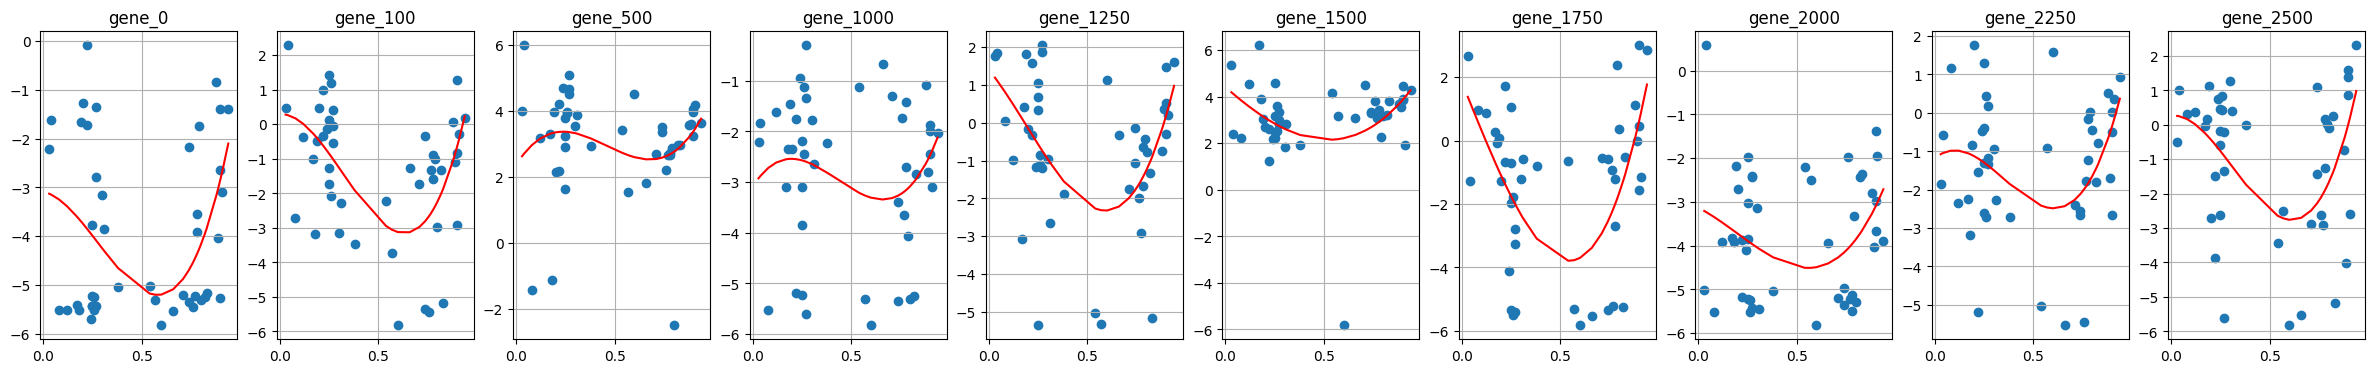

In [33]:
# Curve Fitting
coefficients, fitted_x, errors = func.fit_polynomial(z, res)
# Fitted curves for a few genes (indexes)
ind = [0, 100, 500, 1000, 1250, 1500, 1750, 2000, 2250, 2500]
func.expression_curves(ind, z, fitted_x, res)

## Sample Placement

[0.03 0.04 0.08 0.12 0.17 0.18 0.19 0.2  0.22 0.22 0.24 0.25 0.25 0.25
 0.25 0.26 0.26 0.27 0.27 0.27 0.3  0.31 0.38 0.54 0.57 0.6  0.66 0.71
 0.74 0.74 0.76 0.77 0.78 0.78 0.79 0.8  0.82 0.83 0.88 0.89 0.9  0.9
 0.9  0.91 0.94]


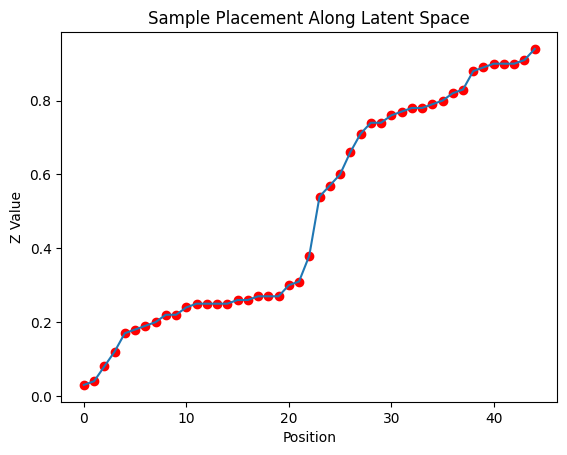

In [34]:
# Pseudo ordering vector
print(np.round(z, 2))
func.sample_placement(z)

# Correlation with clinical scores

In [17]:
df = pd.DataFrame({"samples": smp_order, "z": z})
k = pd.merge(df, df_nb, on="samples")
np.corrcoef(k["z"], k["clinical_score"])[0, 1]

-0.7117042857306021

# Output

In [35]:
df.head()
df.to_csv(output_filename, sep="\t")